In [1]:
import collections
from itertools import chain
import urllib.request as request
import pickle 

import numpy as np

import scipy.signal as signal
import scipy.special as special
import scipy.optimize as optimize

import matplotlib.pyplot as plt

import skimage.io
import skimage.transform

import cv2

from libsvm import svmutil

In [4]:
def normalize_kernel(kernel):
    return kernel / np.sum(kernel)

def gaussian_kernel2d(n, sigma):
    Y, X = np.indices((n, n)) - int(n/2)
    gaussian_kernel = 1 / (2 * np.pi * sigma ** 2) * np.exp(-(X ** 2 + Y ** 2) / (2 * sigma ** 2)) 
    return normalize_kernel(gaussian_kernel)

def local_mean(image, kernel):
    return signal.convolve2d(image, kernel, 'same')

def local_deviation(image, local_mean, kernel):
    "Vectorized approximation of local deviation"
    sigma = image ** 2
    sigma = signal.convolve2d(sigma, kernel, 'same')
    return np.sqrt(np.abs(local_mean ** 2 - sigma))

def calculate_mscn_coefficients(image, kernel_size=6, sigma=7/6):
    C = 1/255
    kernel = gaussian_kernel2d(kernel_size, sigma=sigma)
    local_mean = signal.convolve2d(image, kernel, 'same')
    local_var = local_deviation(image, local_mean, kernel)
    
    return (image - local_mean) / (local_var + C)

def generalized_gaussian_dist(x, alpha, sigma):
    beta = sigma * np.sqrt(special.gamma(1 / alpha) / special.gamma(3 / alpha))
    
    coefficient = alpha / (2 * beta() * special.gamma(1 / alpha))
    return coefficient * np.exp(-(np.abs(x) / beta) ** alpha)

def calculate_pair_product_coefficients(mscn_coefficients):
    return collections.OrderedDict({
        'mscn': mscn_coefficients,
        'horizontal': mscn_coefficients[:, :-1] * mscn_coefficients[:, 1:],
        'vertical': mscn_coefficients[:-1, :] * mscn_coefficients[1:, :],
        'main_diagonal': mscn_coefficients[:-1, :-1] * mscn_coefficients[1:, 1:],
        'secondary_diagonal': mscn_coefficients[1:, :-1] * mscn_coefficients[:-1, 1:]
    })

def asymmetric_generalized_gaussian(x, nu, sigma_l, sigma_r):
    def beta(sigma):
        return sigma * np.sqrt(special.gamma(1 / nu) / special.gamma(3 / nu))
    
    coefficient = nu / ((beta(sigma_l) + beta(sigma_r)) * special.gamma(1 / nu))
    f = lambda x, sigma: coefficient * np.exp(-(x / beta(sigma)) ** nu)
        
    return np.where(x < 0, f(-x, sigma_l), f(x, sigma_r))

In [7]:
def asymmetric_generalized_gaussian_fit(x):
    def estimate_phi(alpha):
        numerator = special.gamma(2 / alpha) ** 2
        denominator = special.gamma(1 / alpha) * special.gamma(3 / alpha)
        return numerator / denominator

    def estimate_r_hat(x):
        size = np.prod(x.shape)
        return (np.sum(np.abs(x)) / size) ** 2 / (np.sum(x ** 2) / size)

    def estimate_R_hat(r_hat, gamma):
        numerator = (gamma ** 3 + 1) * (gamma + 1)
        denominator = (gamma ** 2 + 1) ** 2
        return r_hat * numerator / denominator

    def mean_squares_sum(x, filter = lambda z: z == z):
        filtered_values = x[filter(x)]
        squares_sum = np.sum(filtered_values ** 2)
        return squares_sum / ((filtered_values.shape))

    def estimate_gamma(x):
        left_squares = mean_squares_sum(x, lambda z: z < 0)
        right_squares = mean_squares_sum(x, lambda z: z >= 0)

        return np.sqrt(left_squares) / np.sqrt(right_squares)

    def estimate_alpha(x):
        r_hat = estimate_r_hat(x)
        gamma = estimate_gamma(x)
        R_hat = estimate_R_hat(r_hat, gamma)

        solution = optimize.root(lambda z: estimate_phi(z) - R_hat, [0.2]).x

        return solution[0]

    def estimate_sigma(x, alpha, filter = lambda z: z < 0):
        return np.sqrt(mean_squares_sum(x, filter))
    
    def estimate_mean(alpha, sigma_l, sigma_r):
        return (sigma_r - sigma_l) * constant * (special.gamma(2 / alpha) / special.gamma(1 / alpha))
    
    alpha = estimate_alpha(x)
    sigma_l = estimate_sigma(x, alpha, lambda z: z < 0)
    sigma_r = estimate_sigma(x, alpha, lambda z: z >= 0)
    
    constant = np.sqrt(special.gamma(1 / alpha) / special.gamma(3 / alpha))
    mean = estimate_mean(alpha, sigma_l, sigma_r)
    
    return alpha, mean, sigma_l, sigma_r

In [9]:
def calculate_brisque_features(image, kernel_size=7, sigma=7/6):
    def calculate_features(coefficients_name, coefficients, accum=np.array([])):
        alpha, mean, sigma_l, sigma_r = asymmetric_generalized_gaussian_fit(coefficients)

        if coefficients_name == 'mscn':
            var = (sigma_l ** 2 + sigma_r ** 2) / 2
            return [alpha, var]
        
        return [alpha, mean, sigma_l ** 2, sigma_r ** 2]
    
    mscn_coefficients = calculate_mscn_coefficients(image, kernel_size, sigma)
    coefficients = calculate_pair_product_coefficients(mscn_coefficients)
    
    features = [calculate_features(name, coeff) for name, coeff in coefficients.items()]
    flatten_features = list(chain.from_iterable(features))
    return np.array(flatten_features)

## Auxiliary Functions

In [10]:
def load_image(url):
    image_stream = request.urlopen(url)
    return skimage.io.imread(image_stream, plugin='pil')

def plot_histogram(x, label):
    n, bins = np.histogram(x.ravel(), bins=50)
    n = n / np.max(n)
    plt.plot(bins[:-1], n, label=label, marker='o')

### 1. Load image

libpng warning: iCCP: known incorrect sRGB profile


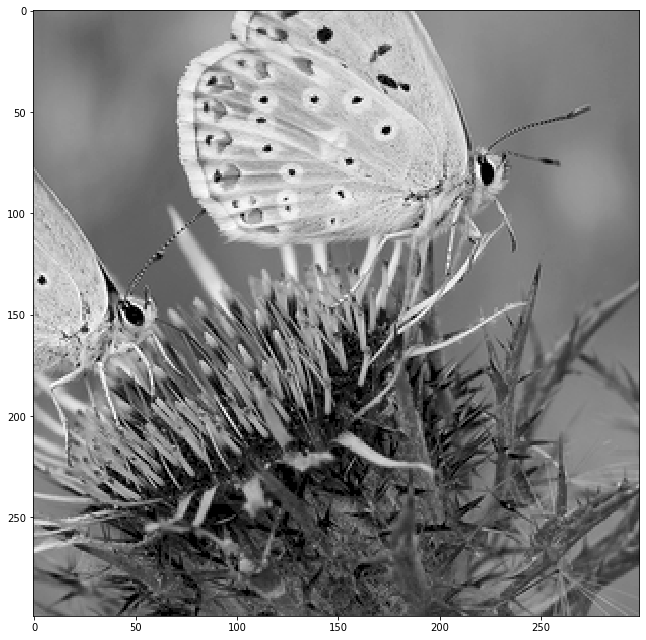

In [13]:
%matplotlib inline
plt.rcParams["figure.figsize"] = 12, 9

image = cv2.imread("butterfly.jpg", 0) # read as gray scale

_ = skimage.io.imshow(image)

### 2. Calculate Coefficients

In [15]:
%%time 

mscn_coefficients = calculate_mscn_coefficients(image, 7, 7/6)
coefficients = calculate_pair_product_coefficients(mscn_coefficients)

CPU times: user 12.9 ms, sys: 4.66 ms, total: 17.6 ms
Wall time: 17.2 ms


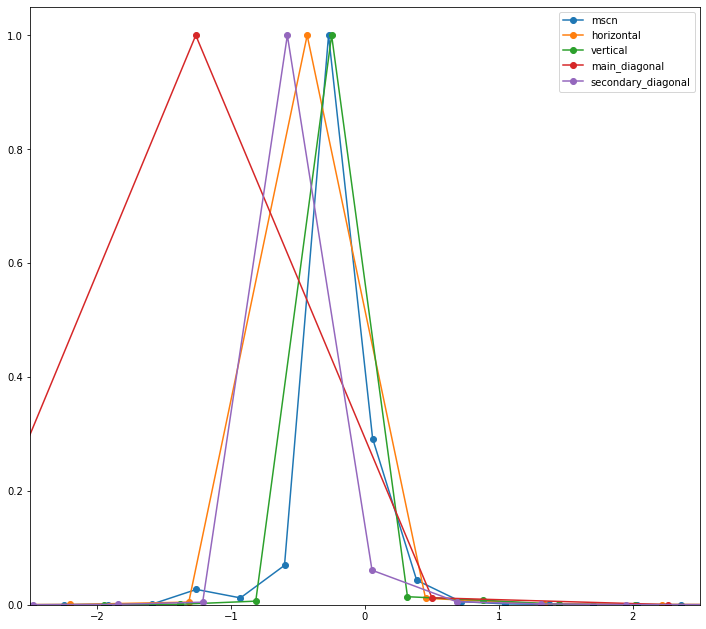

In [16]:
%matplotlib inline
plt.rcParams["figure.figsize"] = 12, 11

for name, coeff in coefficients.items():
    plot_histogram(coeff.ravel(), name)

plt.axis([-2.5, 2.5, 0, 1.05])
plt.legend()
plt.show()

### 3. Fit Coefficients to Generalized Gaussian Distributions

In [18]:
%%time 

brisque_features = calculate_brisque_features(image, kernel_size=7, sigma=7/6)

CPU times: user 28.1 ms, sys: 3.96 ms, total: 32.1 ms
Wall time: 31.5 ms


/tmp/ipykernel_80375/2662786004.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(flatten_features)


### 4. Resize Image and Calculate BRISQUE Features

In [30]:
%%time

downscaled_image = cv2.resize(image, None, fx=1/2, fy=1/2, interpolation = cv2.INTER_CUBIC)
downscale_brisque_features = calculate_brisque_features(downscaled_image, kernel_size=7, sigma=7/6)

brisque_features = np.concatenate((brisque_features, downscale_brisque_features))

CPU times: user 13.6 ms, sys: 0 ns, total: 13.6 ms
Wall time: 13.1 ms


/tmp/ipykernel_80375/2662786004.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(flatten_features)


(72,)

### 5. Scale Features and Feed the SVR

In [27]:
def scale_features(features):
    with open('normalize.pickle', 'rb') as handle:
        scale_params = pickle.load(handle)
    
    min_ = np.array(scale_params['min_'])
    max_ = np.array(scale_params['max_'])
    
    return -1 + (2.0 / (max_ - min_) * (features - min_))

def calculate_image_quality_score(brisque_features):
    model = svmutil.svm_load_model('brisque_svm.txt')
    #scaled_brisque_features = scale_features(brisque_features)
    scaled_brisque_features = brisque_features

    x, idx = svmutil.gen_svm_nodearray(
        scaled_brisque_features,
        isKernel=(model.param.kernel_type == svmutil.PRECOMPUTED))
    
    nr_classifier = 1
    prob_estimates = (svmutil.c_double * nr_classifier)()
    
    return svmutil.libsvm.svm_predict_probability(model, x, prob_estimates)

In [28]:
%%time

calculate_image_quality_score(brisque_features)

CPU times: user 12.3 ms, sys: 0 ns, total: 12.3 ms
Wall time: 9.35 ms


33.69114656062604